# KKS Binary Solidification with FiPy
This notebook contains code for binary solidification using the
Kim-Kim-Suzuki model [1] for interfacial energy. This allows easy specification
of gamma, but requires constant chemical potential through the interface.
The implementation involves iteratively solving for chemical composition in
pure phases such that the chemical potential constraint is satisfied [2].

Questions/comments to trevor.keller@nist.gov (Trevor Keller).

References:
1. Kim, Kim, and Suzuki. "Phase-field model for binary alloys."
    _Physical Review E_ 60:6;7186-7197 (1999). 
2. Provatas and Elder. _Phase-Field Methods in Materials Science and Engineering_,
    Chapter 6, Section 9. Wiley VCH: Weinheim, Germany. 2010.


## Model Description (paraphrased after Provatas & Elder)
We are setting out to simulate solidification of two-component alloy with a lenticular phase diagram, or "binary isomorphous" system, such as Cu-Ni. The free energy curves for pure phases, $f_S$ and $f_L$, are generated from a CALPHAD database, rather than a regular solution model.

In addition to this thermodynamic description, we are adopting the KKS treatment of diffuse interfaces. This simply means that at equilibrium, chemical potential is constant through the interface, and composition varies to make it so. More concretely, composition is defined by the phase fraction $\phi$ and two fictitious concentration fields, $C_S$ and $C_L$, representing composition of the pure phase, as

$$c = h(\phi)C_S + (1-h(\phi))C_L,$$

where the interpolation function $h(\phi)=\phi^3(6\phi^2-15\phi+10)$ takes the values in solid $h(\phi=1)=1$ and liquid $h(\phi=0)=0$. At equilibrium,

$$\mu = \left.\frac{\partial f_S}{\partial c}\right|_{c=C_S} = \left.\frac{\partial f_L}{\partial c}\right|_{c=C_L}.$$

Taken together, and introducing a double-well function $g(\phi)=\phi^2(1-\phi)^2$, the thermodynamic and interfacial treatments provide the bulk free energy,

$$f(\phi,c,T) = \omega g(\phi) + h(\phi)f_S(C_S,T) + (1-h(\phi))f_L(C_L,T).$$

Now, assuming nonconserved (Allen-Cahn) dynamics for $\phi$ and conserved (Cahn-Hilliard) dynamics for $c$, we can write the equations of motion

$$\frac{\partial\phi}{\partial t} = -M_\phi\frac{\delta\mathcal{F}}{\delta\phi} \rightarrow \tau\frac{\partial\phi}{\partial t} = \epsilon_\phi^2\nabla^2\phi -\omega g'(\phi) + h'(\phi)\left[f_L(C_L) - f_S(C_S) - \frac{\partial f_L(C_L)}{\partial c}(C_L - C_S)\right]$$

$$\frac{\partial c}{\partial t} = \nabla\cdot M_c\nabla\frac{\delta\mathcal{F}}{\delta c} = D_L\nabla\cdot Q(\phi)\left[h(\phi)\nabla C_S + (1-h(\phi))\nabla C_L\right]$$

with phase-dependent mobility $Q(\phi)=\frac{1-\phi}{(1+k) - (1-k)\phi}$, partition coefficient $k=\frac{C_S^e}{C_L^e}$, and time constant $\tau = M_\phi^{-1}$.

### The Wrinkle
$C_S$ and $C_L$ are not constants, they are field variables whose values depend on $\phi$ and $c$. Determining their values requires solving for the common tangent, or the coupled roots

$$f_1(C_S,C_L) = h(\phi)C_S + (1-h(\phi))C_L -c = 0$$

$$f_2(C_S,C_L) = \frac{\partial f_S(C_S)}{\partial c} - \frac{\partial f_L(C_L)}{\partial c} = 0.$$

While these equations can be solved using Newton's Method (cf. Provatas & Elder Appendix C.3), it's better to invoke a library, which we'll do a little later on. Even with a highly optimized root solver, determining $(C_S,C_L)$ at every grid point gets prohibitively expensive. The standard approach is to construct a lookup table for $C_S$ and $C_L$ covering $\phi=[-\delta,1+\delta]$ and $c=[-\delta,1+\delta]$ with a reasonably high number of points, then interpolating from the LUT at runtime. For best results, use the interpolated values as initial guesses for a touch-up iteration or two.

## Required Libraries

In [1]:
%matplotlib inline
# high-performance mathematics and visualization
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit, fsolve, newton

# Calphad
from pycalphad import Database, calculate

# phase field
from fipy import CellVariable, Grid2D, DiffusionTerm, Solver, TransientTerm, Variable
from fipy import Matplotlib2DGridViewer, MultiViewer

## Thermodynamics
Rather than a regular solution model, we'll appeal to Calphad for free energy data. Since PyCALPHAD returns points, not curves, we'll fit the data with $10^\mathrm{th}$-order polynomials using SciPy.

In [2]:
# polynomial coefficients from curve fitting to CALPHAD at 1550 K
calCs = [0.]
calCl = [0.]

# pure equilibrium compositions (from solving dfs/dc = 0 and dfl/dc = 0)
Cse = Cle = 0.

# Generate free energy curves with PyCalphad
try:
    with open('CuNi_RWTH.tdb') as file:
        def energy(x, a, b, c, d, e, f, g, h, i, j, k):
            return a*x**10 + b*x**9 + c*x**8 + d*x**7 + e*x**6 + \
                   f*x**5 + g*x**4 + h*x**3 + i*x**2 + j*x + k
        def chempot(x, a, b, c, d, e, f, g, h, i, j):
            return 10*a*x**9 + 9*b*x**8 + 8*c*x**7 + 7*d*x**6 + 6*e*x**5 + \
                    5*f*x**4 + 4*g*x**3 + 3*h*x**2 + 2*i*x + j

        # Import the database
        Vm = 7.124e-4
        db_cuni = Database('CuNi_RWTH.tdb')
        Gs = calculate(db_cuni, ['CU', 'NI', 'VA'], 'FCC_A1', T=1550, output='GM')
        xs = np.ravel(Gs.X.sel(component='NI'))
        ys = np.ravel(Vm * Gs.GM)
        calCs, pcov = curve_fit(energy, xs, ys)
        Cse = newton(chempot, 0.5, args=(calCs[0], calCs[1], calCs[2], calCs[3], calCs[4], \
                                         calCs[5], calCs[6], calCs[7], calCs[8], calCs[9]))
        
        Gl = calculate(db_cuni, ['CU', 'NI', 'VA'], 'LIQUID', T=1550, output='GM')
        xl = np.ravel(Gl.X.sel(component='NI'))
        yl = np.ravel(Vm * Gl.GM)
        calCl, pcov = curve_fit(energy, xl, yl)
        Cle = newton(chempot, 0.5, args=(calCl[0], calCl[1], calCl[2], calCl[3], calCl[4], \
                                         calCl[5], calCl[6], calCl[7], calCl[8], calCl[9]))


except IOError as e:
    print "CALPHAD database file not found, assuming defaults."
    calCs = [6.19383857e+03,-3.09926825e+04, 6.69261368e+04,-8.16668934e+04, \
             6.19902973e+04,-3.04134700e+04, 9.74968659e+03,-2.04529002e+03, \
             2.95622845e+02,-3.70962613e+01,-6.12900561e+01]

    calCl = [6.18692878e+03,-3.09579439e+04, 6.68516329e+04,-8.15779791e+04, \
             6.19257214e+04,-3.03841489e+04, 9.74145735e+03,-2.04379606e+03, \
             2.94796431e+02,-3.39127135e+01,-6.26373908e+01]

    Cse = 0.48300
    Cle = 0.33886


In [3]:
# bulk free energy curves
def fs(c_):
    return   calCs[0]*c_**10 + calCs[1]*c_**9 + calCs[2]*c_**8 + calCs[3]*c_**7 \
           + calCs[4]*c_**6  + calCs[5]*c_**5 + calCs[6]*c_**4 + calCs[7]*c_**3 \
           + calCs[8]*c_**2  + calCs[9]*c_    + calCs[10]

def fl(c_):
    return   calCl[0]*c_**10 + calCl[1]*c_**9 + calCl[2]*c_**8 + calCl[3]*c_**7 \
           + calCl[4]*c_**6  + calCl[5]*c_**5 + calCl[6]*c_**4 + calCl[7]*c_**3 \
           + calCl[8]*c_**2  + calCl[9]*c_    + calCl[10]

# first derivatives
def dfs_dc(c_):
    return  10.0*calCs[0]*c_**9 + 9.0*calCs[1]*c_**8 + 8.0*calCs[2]*c_**7 \
           + 7.0*calCs[3]*c_**6 + 6.0*calCs[4]*c_**5 + 5.0*calCs[5]*c_**4 \
           + 4.0*calCs[6]*c_**3 + 3.0*calCs[7]*c_**2 + 2.0*calCs[8]*c_ + calCs[9];

def dfl_dc(c_):
    return  10.0*calCl[0]*c_**9 + 9.0*calCl[1]*c_**8 + 8.0*calCl[2]*c_**7 \
           + 7.0*calCl[3]*c_**6 + 6.0*calCl[4]*c_**5 + 5.0*calCl[5]*c_**4 \
           + 4.0*calCl[6]*c_**3 + 3.0*calCl[7]*c_**2 + 2.0*calCl[8]*c_ + calCl[9];
            
# second derivatives
def d2fs_dc2(c_):
    return   90.0*calCs[0]*c_**8 + 72.0*calCs[1]*c_**7 + 56.0*calCs[2]*c_**6 \
           + 42.0*calCs[3]*c_**5 + 30.0*calCs[4]*c_**4 + 20.0*calCs[5]*c_**3 \
           + 12.0*calCs[6]*c_**2 +  6.0*calCs[7]*c_    +  2.0*calCs[8]

def d2fl_dc2(c_):
    return   90.0*calCl[0]*c_**8 + 72.0*calCl[1]*c_**7 + 56.0*calCl[2]*c_**6 \
           + 42.0*calCl[3]*c_**5 + 30.0*calCl[4]*c_**4 + 20.0*calCl[5]*c_**3 \
           + 12.0*calCl[6]*c_**2 +  6.0*calCl[7]*c_    +  2.0*calCl[8]



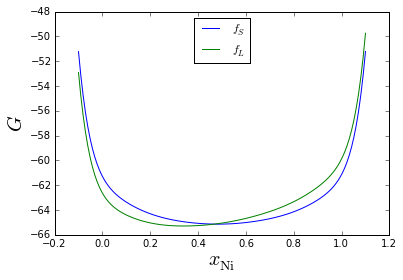

In [4]:
w = np.linspace(-0.1,1.1,125)
plt.plot(w, fs(w), label=('$f_S$'))
plt.plot(w, fl(w), label=('$f_L$'))
plt.xlabel('$x_\mathrm{Ni}$',fontsize=20)
plt.ylabel('$G$',fontsize=20)
plt.legend(loc=9)

## Fictitious composition fields
$C_S$ and $C_L$ are computed using the thermodynamic potentials for pure phases ($f_S$ and $f_L$), interpolation and double-well functions, and a weighting function.

In [5]:
# Interpolation function
def h(phi_):
    return phi_**3 * (6. * phi_**2 - 15. * phi_ + 10.)

def hprime(phi_):
    return 30. * phi_**2 * (1. - 2. * phi_)

# Double well function
def g(phi_):
    return phi_**2 * (1. - phi_)**2

def gprime(phi_):
    return 2. * phi_ * (2. * phi_ - 1.) * (phi_ - 1.)

# Weighting coefficient (W) for Newton's method
def newt_weight(phi_, Cs_, Cl_):
    return h(phi_) * d2fl_dc2(Cl_) + (1. - h(phi_)) * d2fs_dc2(Cs_)

def conc_equality(phi_, c_, Cs_, Cl_):
    # f1 in the itereative scheme: concentration equality
    return h(phi_) * Cs_ + (1. - h(phi_)) * Cl_ - c_

def diff_equality(phi_, c_, Cs_, Cl_):
    # f2 in the iterative scheme: diffusion (or chemical) potential equality
    return dfs_dc(Cs_) - dfl_dc(Cl_)

### Common Tangent solution
We should have everything we need to compute self-consistent values of $C_S$ and $C_L$ given $\phi$ and $c$. Instead of coding Newton's Method by hand, we'll use ```scipy.optimize```, which has excellent libraries for root finding. This follows the approach set forth in FiPy's [```examples.phase.binaryCoupled```](http://www.ctcms.nist.gov/fipy/examples/phase/generated/examples.phase.binaryCoupled.html) code. To use it, we'll feed in the coupled equations

$$ f_1(C_S,C_L) = h(\phi)C_S + (1-h(\phi))C_L -c $$
$$ f_2(C_S,C_L) = \frac{\partial f_S(C_S)}{\partial c} - \frac{\partial f_L(C_L)}{\partial c} $$

and the Jacobian matrix to accelerate convergence,

$$ \mathbf{J} = \left[\begin{array}{c} 
    \frac{\partial f_1}{\partial C_S} & \frac{\partial f_1}{\partial C_L}\\
    \frac{\partial f_2}{\partial C_S} & \frac{\partial f_2}{\partial C_L}
\end{array}\right]  = \left[\begin{array}{c} 
    h(\phi) & 1-h(\phi)\\
    \frac{\partial^2 f_S(C_S)}{\partial c^2} & -\frac{\partial^2 f_L(C_L)}{\partial c^2}
\end{array}\right]. $$

In [6]:
def commonTangentConc(phi_, c_, guessCs, guessCl):
    def equilibrium(C):
        return [h(phi_) * C[0] + (1. - h(phi_)) * C[1] - c_,
                dfs_dc(C[0]) - dfl_dc(C[1])                 ]
    
    def equilibriumJacobian(C):
        return [ [ h(phi_)       , 1. - h(phi_)  ],
                 [ d2fs_dc2(C[0]), -d2fl_dc2(C[1])] ]
    # Return the tuple (CsRoot, ClRoot)
    return fsolve(func=equilibrium, x0=[guessCs, guessCl], fprime=equilibriumJacobian)

## Read or Generate Lookup Table (LUT)
The fictitious single-phase composition fields $(C_S, C_L)$ are expensive to compute at runtime. Therefore, a LUT is generated offline for quick access to close approximations for the $(\phi,c)$ values at each grid point. This should be written as a tab-delimited table (TSV) of coordinates $(\phi,c)$ and values $(C_S,C_L)$.

If any parameters affecting the free energy landscape change, the LUT must be re-generated.

In [7]:
#!rm consistentC.npz

In [8]:
# Provide number of mesh points and mesh spacing for LUT.
# Provide two extra spaces per dimension for a point less than zero and greater than one.
# This enables interpolation at zero and one.
LUTnp = LUTnc = 1026
LUTdp = LUTdc = 1. / (LUTnp - 2)

# Attempt to open consistentC.npz. If it does not exist, create it. 
try:
    with open('consistentC.npz') as file:
        # LUT already exists: no need to generate
        pass
except IOError as e:
    print "Lookup table does not exist: generating from scratch. This should finish within 5 minutes."
    
    # create a mesh over phi and c, 125x125 points
    pureCs = np.zeros(LUTnp * LUTnc).reshape(LUTnp, LUTnc)
    pureCl = np.zeros(LUTnp * LUTnc).reshape(LUTnp, LUTnc)
    
    # iterate over the LUT, ignore stored value
    for (x,y), z in np.ndenumerate(pureCs):
        LUTp = (x - 1) * LUTdp
        LUTc = (y - 1) * LUTdc
        pureCs[x, y], pureCl[x, y] = commonTangentConc(LUTp, LUTc, LUTc, LUTc)
    
    # export Cs, Cl to compressed NumPy format
    np.savez_compressed('consistentC.npz', Cs=pureCs, Cl=pureCl)
    

# LUT either already existed, or has now been written to disk. Read it into memory.
LUTdict = np.load('consistentC.npz')
pureCs = LUTdict['Cs'].reshape(LUTnp, LUTnc)
pureCl = LUTdict['Cl'].reshape(LUTnp, LUTnc)

### Visualize the table
$C_S$ and $C_L$ should vary smoothly over the domain, with the fingerprint of your interpolation function $h(\phi)$ plainly visible.

<matplotlib.colorbar.Colorbar instance at 0x7f1b0d2723b0>

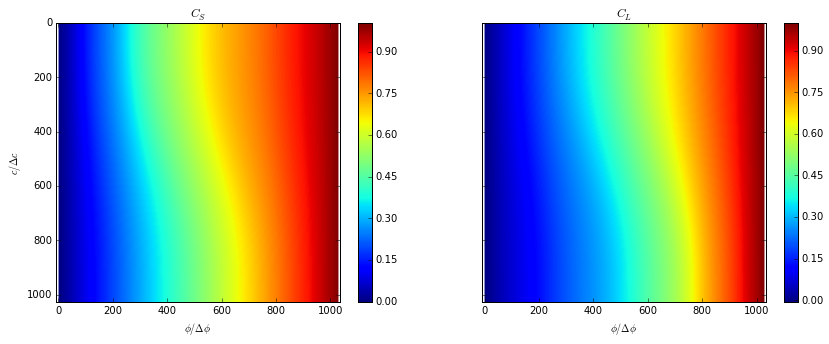

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(14,5))
pltCs = ax1.imshow(pureCs)
ax1.set_title('$C_S$')
ax1.set_xlabel('$\phi/\Delta\phi$')
ax1.set_ylabel('$c/\Delta c$')
plt.colorbar(pltCs, ax=ax1)
pltCl = ax2.imshow(pureCl)
ax2.set_title('$C_L$')
ax2.set_xlabel('$\phi/\Delta\phi$')
plt.colorbar(pltCl, ax=ax2)

# Finally, the science

## Initial Conditions
For testing, the domain contains two circular solid seeds of different radii. The entire domain starts with the same composition.

In [10]:
# Spacetime parameters
nx = ny = 64       # domain size
dx = dy = 0.075    # mesh resolution
dt = Variable(0.1) # initial timestep

# Grid and scalar fields
mesh = Grid2D(nx=nx, ny=ny, dx=dx, dy=dy)
x, y = mesh.cellCenters
phase = CellVariable(mesh=mesh, hasOld=True)
conc  = CellVariable(mesh=mesh, hasOld=True)
Cs    = CellVariable(mesh=mesh, hasOld=False)
Cl    = CellVariable(mesh=mesh, hasOld=False)
# Would a vector-valued variable make more sense than four separate scalar fields?
# Default boundary conditions are... ?

In [11]:
def initialize():
    # Flat field initializations
    conc[:] = (Cse + Cle)/2.
    phase[:] = 0.
    Cs[:] = (Cse + Cle)/2.
    Cl[:] = (Cse + Cle)/2.
    
    # Initial microstructure
    rA = 20. * dx
    rB = 16. * dx
    cA = (     nx * dx / 3.,      ny * dy / 3.)
    cB = (3. * nx * dx / 4., 3. * ny * dy / 4.)
    mask = ((x - cA[0])**2 + (y - cA[1])**2 < rA**2) + \
           ((x - cB[0])**2 + (y - cB[1])**2 < rB**2)
    phase.setValue(1., where=mask)

initialize()

### Build a Viewer
This is a simple custom viewer (cf. [```examples.phase.anisotropy```](http://www.ctcms.nist.gov/fipy/examples/phase/generated/examples.phase.anisotropy.html)) that places the two variables $(\phi,c)$ side-by-side in the notebook, wrapped inside a ```MultiViewer``` so that updating takes only one command.

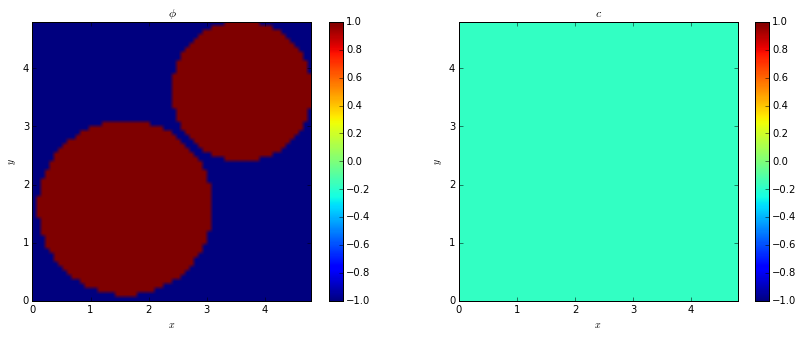

In [12]:
# Visualize initial conditions
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(14,5))
fig = plt.figure()
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')

viewer = MultiViewer(viewers = (Matplotlib2DGridViewer(vars=phase, title='$\phi$', axes=ax1), \
                                Matplotlib2DGridViewer(vars=conc,  title='$c$', axes=ax2)))